# **Deep Learning** Final Project

---


### Students:

*   **Zihadul Azam** [MAT. 221747]
*   **Ali Hamza** [MAT. 225088]
*   **Sabbavarapu Hanusha** [MAT. 225018]

---

## Task 2: ReIdentification

This was our fist solution. It is a very simple solution, take the trained model of the first task (classification), remove the classification layers such that we can get the feature values if we feed an image as input.  We extract feature vectors from the model for each of the query images and the gallery images (test images). Then, we can calculate the similarity between query images and gallery images (bwetween feature vectors) using `cosine-similarity` function. This is a very simple and time saving solution, because it does not require any further training process for the second task. The model was evaluated using the Mean Average Precision (mAP) metric. But the produced mAP score was not that bad and also not that good, so we decided to go for a solution based on `joint loss` (triplet loss + person_id loss).


---

Below you can see the solution (based on the classification model) and its mAP score.

### Import Libraries

In [ ]:
import zipfile
import os
import random
from tqdm.notebook import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as tt
from torchvision.io import read_image
from torchvision.utils import make_grid
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from skimage import io, transform
from sklearn.metrics.pairwise import cosine_similarity


# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
print(torch.__version__)

1.9.0+cu102


### Global Vars

In [ ]:
batch_size = 32
epochs = 100

### Import input data

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Set data folder path here

In [ ]:
current_folder_path = '/content/drive/MyDrive/Colab Notebooks/DL'
input_folder_path = '/content/drive/MyDrive/Colab Notebooks/DL/data-folder'
dataset_folder_path = input_folder_path + '/dataset'

Unzip dataset folder

In [ ]:
!unzip -q '/content/drive/MyDrive/Colab Notebooks/DL/data-folder/dataset'

replace annotations_train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
!ls

annotations_train.csv  reid_train_annotations.csv  test
drive		       reid_val_annotations.csv    train
queries		       sample_data


### Device

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda:0')
    else:
        return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cuda', index=0)

## Load classification model and drop last layers
So the model will return only embedding (features)


To load the saved model first we have to define the original model structure. Here it is (copy and paste from the first task):

In [ ]:
# this is the structure of the model used during classification task
class CustomResNet50(nn.Module):
  def __init__(self, n_age_classes, n_bagpack_classes, n_bag_classes, n_handbag_classes,
      n_clothes_classes, n_down_classes, n_up_classes, n_hair_classes, n_hat_classes, n_gender_classes, n_upcolor_classes, n_downcolor_classes, dropout_p=0.4):
    super(CustomResNet50, self).__init__()
    
    backbone = torchvision.models.resnet50(pretrained=True)
    self.fc_inputs = backbone.fc.in_features
    layers = list(backbone.children())[:-1]
    # as base model we take all the layers of resnet50 except last layer
    # becase resnet default output is different respect our outputs
    self.feature_extractor = nn.Sequential(*layers)

    # create separate classifiers for our outputs
    self.age = nn.Sequential(nn.Dropout(p=dropout_p), nn.Linear(self.fc_inputs,1000), nn.ReLU(), nn.Dropout(p=dropout_p), nn.Linear(1000,n_age_classes))
    self.bagpack = nn.Sequential(nn.Dropout(p=dropout_p), nn.Linear(self.fc_inputs,1000), nn.ReLU(), nn.Dropout(p=dropout_p), nn.Linear(1000,n_bagpack_classes))
    self.bag = nn.Sequential(nn.Dropout(p=dropout_p), nn.Linear(self.fc_inputs,1000), nn.ReLU(), nn.Dropout(p=dropout_p), nn.Linear(1000,n_bag_classes))
    self.handbag = nn.Sequential(nn.Dropout(p=dropout_p), nn.Linear(self.fc_inputs,1000), nn.ReLU(), nn.Dropout(p=dropout_p), nn.Linear(1000,n_handbag_classes))
    self.clothes = nn.Sequential(nn.Dropout(p=dropout_p), nn.Linear(self.fc_inputs,1000), nn.ReLU(), nn.Dropout(p=dropout_p), nn.Linear(1000,n_clothes_classes))
    self.down = nn.Sequential(nn.Dropout(p=dropout_p), nn.Linear(self.fc_inputs,1000), nn.ReLU(), nn.Dropout(p=dropout_p), nn.Linear(1000,n_down_classes))
    self.up = nn.Sequential(nn.Dropout(p=dropout_p), nn.Linear(self.fc_inputs,1000), nn.ReLU(), nn.Dropout(p=dropout_p), nn.Linear(1000,n_up_classes))
    self.hair = nn.Sequential(nn.Dropout(p=dropout_p), nn.Linear(self.fc_inputs,1000), nn.ReLU(), nn.Dropout(p=dropout_p), nn.Linear(1000,n_hair_classes))
    self.hat = nn.Sequential(nn.Dropout(p=dropout_p), nn.Linear(self.fc_inputs,1000), nn.ReLU(), nn.Dropout(p=dropout_p), nn.Linear(1000,n_hat_classes))
    self.gender = nn.Sequential(nn.Dropout(p=dropout_p), nn.Linear(self.fc_inputs,1000), nn.ReLU(), nn.Dropout(p=dropout_p), nn.Linear(1000,n_gender_classes))
    self.upcolor = nn.Sequential(nn.Dropout(p=dropout_p), nn.Linear(self.fc_inputs,1000), nn.ReLU(), nn.Dropout(p=dropout_p), nn.Linear(1000,n_upcolor_classes))
    self.downcolor = nn.Sequential(nn.Dropout(p=dropout_p), nn.Linear(self.fc_inputs,1000), nn.ReLU(), nn.Dropout(p=dropout_p), nn.Linear(1000,n_downcolor_classes))

  def forward(self, x):
    x = self.feature_extractor(x)
    x = x.view(x.size(0), -1)

    return {
        'age': self.age(x),
        'backpack': self.bagpack(x),
        'bag': self.bag(x),
        'handbag': self.handbag(x),
        'clothes': self.clothes(x),
        'down': self.down(x),
        'up': self.up(x),
        'hair': self.hair(x),
        'hat': self.hat(x),
        'gender': self.gender(x),
        'upcolor': self.upcolor(x),
        'downcolor': self.downcolor(x)
    }

In [ ]:
classification_model_path = current_folder_path + '/classification_model.pth'

In [ ]:
# load the pre-trined model
trained_classification_model = torch.load(classification_model_path)

Now drop all classification FC layers, we return only the feature vector

In [ ]:
class ReIdModel(nn.Module):
    def __init__(self, pre_trained_model):
        super(ReIdModel, self).__init__()
        self.feature_extractor = nn.Sequential(*list(pre_trained_model.children())[0])
    
    def forward(self, x):
        x = self.feature_extractor(x)
        out = x.view(x.size(0), -1)
        return out

In [ ]:
classifier_model = ReIdModel(trained_classification_model)
classifier_model

ReIdModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0):

## Data Loader

In [ ]:
ann_csv_path = 'annotations_train.csv'
annotations_train_csv = pd.read_csv(ann_csv_path)

annotations_train_csv.head()

,id,age,backpack,bag,handbag,clothes,down,up,hair,hat,gender,upblack,upwhite,upred,uppurple,upyellow,upgray,upblue,upgreen,downblack,downwhite,downpink,downpurple,downyellow,downgray,downblue,downgreen,downbrown
0,474,2,1,1,1,1,2,2,2,1,2,1,2,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1
1,857,2,1,2,1,2,2,2,2,1,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2
2,1487,2,2,1,1,2,2,2,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1
3,1422,2,1,2,1,2,2,2,1,1,1,1,2,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1
4,856,2,2,1,1,2,2,2,2,1,2,1,2,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1


In [ ]:
# imgs from the train folder
train_imgs = os.listdir('train')
# get the image id from it's file name
train_imgs_data = []
for s in train_imgs:
  train_imgs_data.append([int(s.split('_')[0]), s])

train_imgs_df = pd.DataFrame(train_imgs_data, columns=['id', 'filename'])

train_imgs_df.head()

,id,filename
0,1304,1304_c6_070585431.jpg
1,1481,1481_c5_024242228.jpg
2,1062,1062_c3_089462591.jpg
3,1199,1199_c5_061013173.jpg
4,1481,1481_c6_089229603.jpg


In [ ]:
annotations_train = pd.merge(annotations_train_csv, train_imgs_df, on='id')

# now we have filename column (last one) also inside the annotations dataframe
annotations_train

,id,age,backpack,bag,handbag,clothes,down,up,hair,hat,gender,upblack,upwhite,upred,uppurple,upyellow,upgray,upblue,upgreen,downblack,downwhite,downpink,downpurple,downyellow,downgray,downblue,downgreen,downbrown,filename
0,474,2,1,1,1,1,2,2,2,1,2,1,2,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,0474_c5_013563167.jpg
1,474,2,1,1,1,1,2,2,2,1,2,1,2,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,0474_c5_087766632.jpg
2,474,2,1,1,1,1,2,2,2,1,2,1,2,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,0474_c5_046017229.jpg
3,474,2,1,1,1,1,2,2,2,1,2,1,2,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,0474_c1_098614695.jpg
4,474,2,1,1,1,1,2,2,2,1,2,1,2,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,0474_c2_007717494.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12984,1177,2,2,1,1,2,2,2,2,1,2,1,2,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1177_c2_028331321.jpg
12985,1177,2,2,1,1,2,2,2,2,1,2,1,2,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1177_c6_001668358.jpg
12986,1177,2,2,1,1,2,2,2,2,1,2,1,2,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1177_c2_053033722.jpg
12987,1177,2,2,1,1,2,2,2,2,1,2,1,2,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1177_c3_037640775.jpg


In [ ]:
reid_train_annotations = annotations_train[['id', 'filename']]

### **Split data for Training and Validation**

We will split train data into:

*   validation data: `last 100 unique identities`
*   training data: `the rest`

We use `651 identities` in training set for training and the other `100 identities` are used as the validation set.



In [ ]:
# get unique ids
unique_ids = reid_train_annotations.id.unique() 
# now we split ids into training and valid set
# last 100 is our validation data set
# the rest is for trining
valid_ids = unique_ids[-100:]
train_ids = unique_ids[:-100]

In [ ]:
print('Trining identities len: ', len(train_ids))
print('Validation identities len: ', len(valid_ids))

Trining identities len:  651
Validation identities len:  100


Now split annotations into traning and validation, then save annotations as two separated csv files.

In [ ]:
# get valid mask
valid_mask = reid_train_annotations['id'].isin(valid_ids)

In [ ]:
# train dataframe (annotations)
train_df = reid_train_annotations.loc[~valid_mask]
train_df

,id,filename
0,474,0474_c5_013563167.jpg
1,474,0474_c5_087766632.jpg
2,474,0474_c5_046017229.jpg
3,474,0474_c1_098614695.jpg
4,474,0474_c2_007717494.jpg
...,...,...
11590,473,0473_c6_057027515.jpg
11591,473,0473_c6_076139706.jpg
11592,473,0473_c3_065315908.jpg
11593,473,0473_c5_010339677.jpg


In [ ]:
# valid dataframe (annotations)
valid_df = reid_train_annotations.loc[valid_mask]
valid_df

,id,filename
11595,565,0565_c4_016746442.jpg
11596,565,0565_c5_058384193.jpg
11597,565,0565_c4_082478734.jpg
11598,565,0565_c1_032090754.jpg
11599,565,0565_c5_070138317.jpg
...,...,...
12984,1177,1177_c2_028331321.jpg
12985,1177,1177_c6_001668358.jpg
12986,1177,1177_c2_053033722.jpg
12987,1177,1177_c3_037640775.jpg


In [ ]:
# save them as csv
pd.DataFrame(train_df).to_csv('reid_train_annotations.csv', index=False)
pd.DataFrame(valid_df).to_csv('reid_val_annotations.csv', index=False)

### Custom Dataset



In [ ]:
class ReIdMarketDataset(Dataset):
  """ Market ReID dataset """

  def __init__(self, csv_file, root_dir, transform=None, has_id_info = False):
    """
    Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.annotations_frame = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform
    self.has_id_info = has_id_info

  def __len__(self):
      return len(self.annotations_frame)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
        idx = idx.tolist()

    img_path = os.path.join(self.root_dir, str(self.annotations_frame.iloc[idx, -1]))
    img = io.imread(img_path)
    img_id = int(self.annotations_frame.iloc[idx, 0])
    img_filename = str(self.annotations_frame.iloc[idx, -1])

    sample = {
        'image': img,
        'image_id': img_id,
        'image_path': img_path,
        'image_filename': img_filename
    }

    if self.transform:
        sample['image'] = self.transform(sample['image'])

    return sample

In [ ]:
tr_dataset = ReIdMarketDataset('reid_train_annotations.csv', 'train/')
val_dataset = ReIdMarketDataset('reid_val_annotations.csv', 'train/')

print('Train dataset len: ', len(tr_dataset))
print('Valid dataset len: ', len(val_dataset))

Train dataset len:  11595
Valid dataset len:  1394


### Data augmentation
Channel-wise normalization + Data augmentations

In [ ]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_tfms = tt.Compose([
    tt.ToPILImage(),
    tt.RandomCrop((128, 64), padding=8, padding_mode='reflect'),
    tt.RandomHorizontalFlip(p=0.5), 
    tt.RandomRotation(10),
    tt.ToTensor(), 
    tt.Normalize(*imagenet_stats,inplace=True), 
    tt.RandomErasing(p=0.5, inplace=True)
])

valid_tfms = tt.Compose([
    tt.ToTensor(), 
    tt.Normalize(*imagenet_stats)
])

### Data loader

In [ ]:
def get_data_loaders(train_csv, val_csv, batch_size=100):
  train_ds = ReIdMarketDataset(train_csv, 'train/', transform=train_tfms)
  val_ds = ReIdMarketDataset(val_csv, 'train/', transform=valid_tfms)

  train_dloader = torch.utils.data.DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
  valid_dloader = torch.utils.data.DataLoader(val_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

  return train_dloader, valid_dloader

In [ ]:
_, valid_dloader = get_data_loaders('reid_train_annotations.csv', 'reid_val_annotations.csv', batch_size=batch_size)

In [ ]:
def show_batch(dl):
  for data in dl:
    fig, ax = plt.subplots(figsize=(32, 16))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(data['image'][:32], nrow=8).squeeze().permute(1, 2, 0).clamp(0,1))
    break

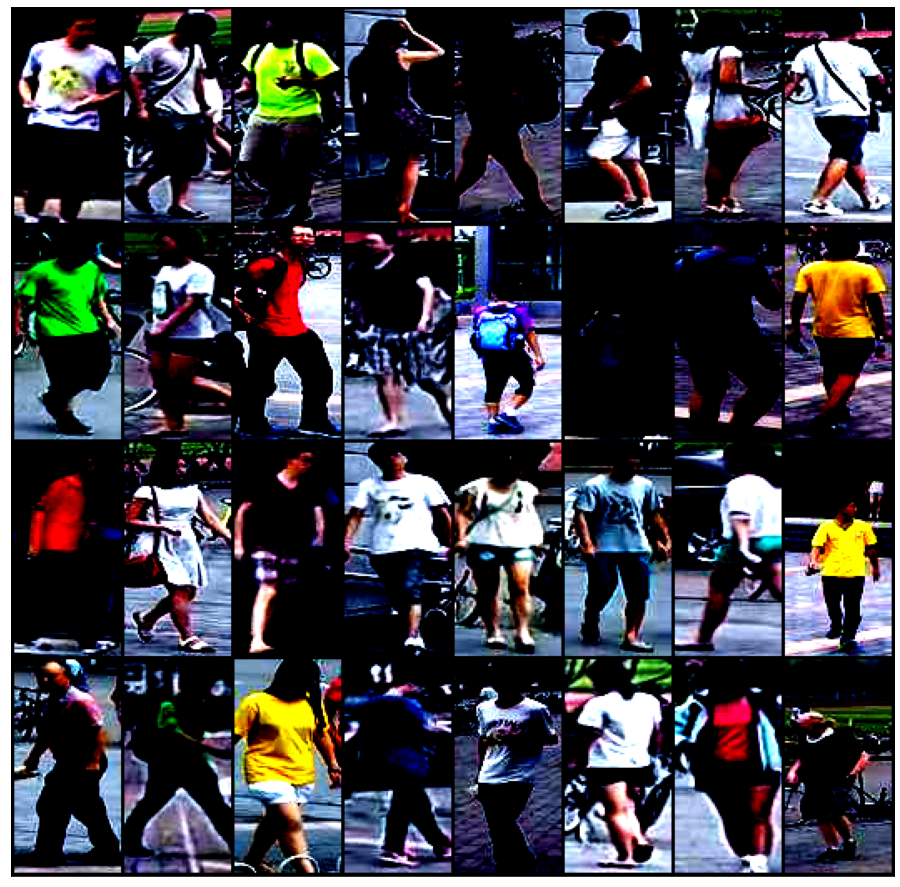

In [ ]:
show_batch(valid_dloader)

## Validation set mAP evaluation

In [ ]:
# load classification valid data
valid_df = pd.read_csv('reid_val_annotations.csv')
valid_df

,id,filename
0,565,0565_c4_016746442.jpg
1,565,0565_c5_058384193.jpg
2,565,0565_c4_082478734.jpg
3,565,0565_c1_032090754.jpg
4,565,0565_c5_070138317.jpg
...,...,...
1389,1177,1177_c2_028331321.jpg
1390,1177,1177_c6_001668358.jpg
1391,1177,1177_c2_053033722.jpg
1392,1177,1177_c3_037640775.jpg


In [ ]:
# get unique IDs
unique_val = sorted(valid_df['id'].unique())
unique_val[:10]

[2, 22, 72, 83, 88, 98, 104, 116, 123, 168]

In [ ]:
# for each unique id we create query list and its ground truth
query_ids = []
valid_ground_truth_list = []
for id in unique_val:
  candidates = valid_df[valid_df['id']==id].index
  q_id = random.choice(candidates)
  q_filename = valid_df.iloc[q_id, -1]
  query_ids.append(q_id)
  # ground truth
  truth_vals = valid_df.loc[(valid_df['id']==id) & (valid_df['filename']!=q_filename)]
  truth_vals['query']=q_filename
  valid_ground_truth_list.extend(truth_vals[['query', 'filename']].values.tolist())

valid_ground_truth=pd.DataFrame(valid_ground_truth_list, columns=['query', 'pos_img'])
valid_ground_truth

,query,pos_img
0,0002_c3_010187163.jpg,0002_c3_093017288.jpg
1,0002_c3_010187163.jpg,0002_c3_027735928.jpg
2,0002_c3_010187163.jpg,0002_c5_048766132.jpg
3,0002_c3_010187163.jpg,0002_c5_089121687.jpg
4,0002_c3_010187163.jpg,0002_c1_016620005.jpg
...,...,...
1289,1486_c4_035770009.jpg,1486_c5_048819605.jpg
1290,1486_c4_035770009.jpg,1486_c3_077380226.jpg
1291,1486_c4_035770009.jpg,1486_c5_073973019.jpg
1292,1486_c4_035770009.jpg,1486_c4_090252255.jpg


In [ ]:
# transform in dict
valid_ground_truth = valid_ground_truth.groupby('query')['pos_img'].apply(list).to_dict()
valid_ground_truth

{'0002_c3_010187163.jpg': ['0002_c3_093017288.jpg',
  '0002_c3_027735928.jpg',
  '0002_c5_048766132.jpg',
  '0002_c5_089121687.jpg',
  '0002_c1_016620005.jpg',
  '0002_c5_040638433.jpg'],
 '0022_c5_050853338.jpg': ['0022_c6_089309432.jpg',
  '0022_c1_062291157.jpg',
  '0022_c3_084337591.jpg',
  '0022_c1_017682046.jpg',
  '0022_c2_020703702.jpg',
  '0022_c6_016437652.jpg',
  '0022_c2_052444996.jpg',
  '0022_c2_057400307.jpg',
  '0022_c5_098540311.jpg',
  '0022_c3_094044445.jpg'],
 '0072_c5_003188430.jpg': ['0072_c1_073975033.jpg',
  '0072_c2_069980291.jpg',
  '0072_c3_094761428.jpg',
  '0072_c2_077025868.jpg',
  '0072_c3_014821433.jpg',
  '0072_c3_026495328.jpg'],
 '0083_c2_031895710.jpg': ['0083_c6_076916613.jpg',
  '0083_c2_083171672.jpg',
  '0083_c2_073521504.jpg',
  '0083_c3_002917699.jpg',
  '0083_c3_045721912.jpg',
  '0083_c6_081678977.jpg',
  '0083_c1_035229859.jpg',
  '0083_c6_085509802.jpg',
  '0083_c1_071359375.jpg',
  '0083_c5_015927760.jpg',
  '0083_c1_082040647.jpg',
  '008

Now create query dataframe

In [ ]:
query_ids[:10]

[1287, 234, 1237, 706, 114, 777, 960, 937, 909, 529]

In [ ]:
query_df = valid_df.iloc[query_ids, :]
query_df

,id,filename
1287,2,0002_c3_010187163.jpg
234,22,0022_c5_050853338.jpg
1237,72,0072_c5_003188430.jpg
706,83,0083_c2_031895710.jpg
114,88,0088_c5_099500423.jpg
...,...,...
1090,1409,1409_c3_026871670.jpg
1305,1411,1411_c5_086979011.jpg
221,1440,1440_c3_092630050.jpg
390,1441,1441_c3_042846583.jpg


In [ ]:
# create a list of query_img filename
query_filenames = query_df[['filename']].to_numpy()
query_filenames = query_filenames.reshape(-1)
query_filenames[:10]

array(['0002_c3_010187163.jpg', '0022_c5_050853338.jpg',
       '0072_c5_003188430.jpg', '0083_c2_031895710.jpg',
       '0088_c5_099500423.jpg', '0098_c3_035308785.jpg',
       '0104_c6_028198331.jpg', '0116_c5_086200761.jpg',
       '0123_c5_015197537.jpg', '0168_c2_022749476.jpg'], dtype=object)

Now, We take the valid dataloader.

Then for each img in data loader we extract its feature vector from the model

In [ ]:
classifier_model.eval()

valid_emb_values = []
img_names = []
img_ids = []
with torch.no_grad():
  for batch_idx, input_data in enumerate(tqdm(valid_dloader)):
    img = input_data['image'].to(device)
    img_filename = input_data['image_filename']
    img_id = input_data['image_id']

    # get feature values
    outputs = classifier_model(img.float())
    
    valid_emb_values.append(outputs.cpu().numpy())
    img_names.append(img_filename)
    img_ids.append(img_id)

valid_emb_values = np.concatenate(valid_emb_values)
img_names = np.concatenate(img_names)
img_ids = np.concatenate(img_ids)

  0%|          | 0/44 [00:00<?, ?it/s]

In [ ]:
valid_emb_values_df = pd.DataFrame(valid_emb_values)
valid_emb_values_df['filename'] = img_names
valid_emb_values_df['id'] = img_ids
valid_emb_values_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,filename,id
0,0.271136,1.981020,0.086869,0.000000,1.698032,0.272934,2.153536,2.487150,0.026605,0.277769,0.689302,0.890284,0.492542,0.227017,0.836933,0.015567,2.090357,0.029895,0.936370,0.000000,0.471179,0.088263,2.753175,0.000000,1.110087,0.349233,0.264545,0.526022,1.006316,0.098100,0.621760,0.173287,0.575159,0.770497,0.133811,0.000000,0.000000,0.059046,0.003183,1.045497,...,1.264006,0.535472,1.748144,0.946134,1.767149,0.382975,0.000000,0.000000,1.114066,0.000000,0.519087,0.297067,0.081298,1.434251,0.014952,1.289866,1.069731,0.809541,0.000000,0.076949,0.070727,0.285895,2.318607,0.099924,0.377490,0.440904,0.307584,0.000000,0.788294,1.266267,0.000000,0.061870,2.377422,0.164844,2.130957,0.000000,0.813798,1.606869,0002_c3_010187163.jpg,2
1,1.552309,0.005468,1.361681,0.387369,1.020453,0.000000,0.730311,0.126221,0.524702,1.166411,0.038003,0.514920,1.035728,1.804277,0.000000,0.214603,0.013137,0.366677,0.000000,0.608376,0.218278,1.044744,0.502126,1.325033,1.319950,0.805679,0.266145,0.204822,0.301516,0.549653,1.396396,0.674530,0.284459,0.309013,0.129383,0.457716,0.113894,0.262082,0.191291,1.301463,...,0.323786,0.758115,0.000000,1.402223,0.208886,0.269335,0.883798,3.659912,1.760291,0.045037,0.533150,0.859367,2.024022,0.085365,0.882328,0.980356,0.122359,0.282903,2.105142,0.419313,0.519957,0.933963,0.745707,0.087945,0.000000,1.902450,0.106030,0.192932,0.257255,0.000000,1.618098,1.609313,1.441426,0.405443,0.472241,1.345371,2.559148,1.320048,0277_c1_033658801.jpg,277
2,0.036743,1.489802,0.000000,0.000000,1.791699,0.483201,0.920156,0.603154,0.008476,0.507506,0.888657,0.070119,0.000000,0.000000,1.380684,0.000000,0.518234,0.008703,0.133193,0.166896,0.985789,0.170667,0.359967,0.000000,0.000000,1.755766,2.273984,0.000000,0.033392,0.250872,0.000000,0.436721,0.221290,0.000000,0.000000,1.749049,0.897159,0.859593,0.105081,0.000000,...,0.374985,0.000000,2.076161,0.063648,0.349118,0.059998,0.054309,0.000000,0.656421,0.347886,0.138291,0.003498,0.000000,0.318715,0.013870,0.000000,0.218381,1.010058,0.000000,0.063924,0.565379,0.531702,0.574736,0.054591,0.431473,1.846619,1.421811,0.000000,0.564243,0.388369,0.029733,0.113766,0.372572,0.019709,0.173447,0.012378,1.068142,0.355397,0798_c4_046146418.jpg,798
3,0.000000,1.093005,0.000000,0.195360,0.817957,0.873766,0.224177,1.564265,0.039603,0.446033,0.372490,1.387066,0.160335,0.000000,0.044775,0.100520,0.396298,0.000000,0.971867,0.000000,0.234843,0.000000,1.639290,0.000000,1.312675,0.012366,0.076014,0.197616,0.725434,0.074071,1.166780,0.644246,0.000000,0.238098,0.033995,0.265472,0.563966,0.023209,0.226429,0.152865,...,0.400553,0.601790,0.885657,0.995804,0.972435,0.006984,0.029222,0.000000,1.976134,0.000000,0.862819,0.137168,0.355843,0.251657,0.001211,0.380971,0.045057,0.355188,0.760228,0.223047,0.000000,0.062888,0.696748,0.000000,0.003431,0.057088,0.679570,0.000000,0.173540,1.939475,0.017825,0.005558,0.994724,0.172911,0.490727,0.058221,0.196203,0.282843,1301_c3_030911725.jpg,1301
4,1.334454,0.055463,0.028522,1.155416,0.093471,0.041849,1.043601,0.086745,0.663038,0.275721,0.427852,1.257771,0.223522,0.000000,0.028459,0.000000,0.023070,0.377867,1.252634,1.004291,0.158708,0.367366,0.024778,0.181086,1.827056,0.028431,0.254730,0.093978,1.071411,0.049779,1.264001,1.422563,0.107506,0.560201,0.013577,0.126480,0.628848,0.062402,0.059843,2.287397,...,0.055762,0.448291,0.000000,1.731789,1.496732,0.001088,0.301023,0.578579,0.292702,0.000000,0.246113,0.154495,1.204625,0.026805,0.583525,1.577909,0.000000,0.172342,0.449260,0.000000,0.760034,0.816721,0.000000,0.973819,0.000000,0.000000,0.598684,0.153911,0.000000,0.019142,0.386102,0.413040,0.562547,0.246764,0.772631,1.087834,0.596590,0.000000,0593_c6_071487463.jpg,593
...,...,...,..

Now we have to extract query images from the `valid_emb_values_df` Dataframe

In [ ]:
query_emb_df = valid_emb_values_df.merge(query_df, how='inner', on='filename')
query_emb_df = query_emb_df.iloc[:, :-1]
query_emb_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,filename,id_x
0,0.271136,1.981020,0.086869,0.000000,1.698032,0.272934,2.153536,2.487150,0.026605,0.277769,0.689302,0.890284,0.492542,0.227017,0.836933,0.015567,2.090357,0.029895,0.936370,0.000000,0.471179,0.088263,2.753175,0.000000,1.110087,0.349233,0.264545,0.526022,1.006316,0.098100,0.621760,0.173287,0.575159,0.770497,0.133811,0.000000,0.000000,0.059046,0.003183,1.045497,...,1.264006,0.535472,1.748144,0.946134,1.767149,0.382975,0.000000,0.000000,1.114066,0.000000,0.519087,0.297067,0.081298,1.434251,0.014952,1.289866,1.069731,0.809541,0.000000,0.076949,0.070727,0.285895,2.318607,0.099924,0.377490,0.440904,0.307584,0.000000,0.788294,1.266267,0.000000,0.061870,2.377422,0.164844,2.130957,0.000000,0.813798,1.606869,0002_c3_010187163.jpg,2
1,0.412127,0.609875,0.055876,0.073845,0.783841,0.486571,0.042466,2.915731,1.600447,0.632107,0.266488,0.017860,1.036507,0.000000,0.540560,1.286722,0.002555,0.012555,0.356150,0.034335,0.339783,0.221624,2.081978,0.000000,0.320504,0.000000,1.898435,0.000000,0.000000,0.792759,0.000000,0.318171,1.212221,0.048938,0.432862,2.739932,1.404452,0.042463,0.157877,0.123920,...,0.778731,0.095622,0.346151,0.002521,0.080450,0.072063,0.189227,0.000000,1.262977,1.058508,0.000000,0.097524,0.036020,0.082301,0.335615,0.225924,0.963876,0.250321,0.038361,0.355989,0.564085,0.202781,0.677175,0.000000,0.503195,0.098479,1.461420,0.113001,0.514744,1.600309,0.000000,0.289457,0.000000,0.116494,0.021624,0.351828,0.000000,1.022656,0624_c2_049381513.jpg,624
2,0.144213,1.168084,0.118272,0.517827,0.068980,1.133749,0.046292,2.227277,0.682962,0.238513,0.956987,0.512158,1.234594,0.000000,0.447227,0.394476,0.574162,0.013014,0.126813,0.000000,0.072339,0.145317,2.408089,1.306459,0.048050,1.712647,1.892431,0.926164,0.031678,0.217550,0.011237,0.125556,1.045311,0.059819,1.015528,0.000000,0.115234,0.885030,0.104763,1.489549,...,0.997997,1.209235,0.138399,0.000000,0.265495,0.460629,0.000000,0.883482,0.824571,0.364990,0.819931,0.298431,0.197355,1.785883,0.166659,0.330863,1.656161,0.288962,0.035163,1.546088,0.907757,0.234105,1.256508,0.514777,0.221696,1.771332,1.115325,0.448173,2.615265,1.362077,0.000000,0.675160,0.762518,0.203906,0.642904,0.030310,0.054525,0.698655,0104_c6_028198331.jpg,104
3,1.686459,0.051688,0.000000,0.981287,0.778512,1.273603,0.000000,3.034594,0.043812,2.129483,0.207554,0.280048,0.121547,0.000000,0.076034,0.044838,0.000000,0.060311,0.029444,0.440731,1.363670,0.000000,2.786090,0.302297,0.757019,0.023242,0.711120,0.000000,1.759599,2.366330,0.096471,0.980049,0.532503,0.015197,0.000000,1.989583,0.992435,0.000609,0.329278,0.213976,...,2.093949,0.452957,0.000000,0.685675,0.100985,0.050493,0.000000,0.018261,0.297191,1.978424,0.370064,0.000000,1.134545,0.757092,0.055383,1.548568,1.825540,0.001573,0.076080,0.147884,0.000000,1.125437,0.966106,0.000000,0.001673,0.357568,1.064141,0.025834,1.459606,0.145718,1.871816,0.221226,0.062911,0.000000,0.757992,1.069831,0.380485,0.445451,0847_c3_056749683.jpg,847
4,0.286863,1.851041,0.000000,0.450729,0.299422,0.783403,0.131184,0.456000,0.214088,1.643719,0.805722,0.598177,0.000000,0.475952,1.074310,0.288882,1.789501,0.624720,0.849489,0.105546,0.450072,0.032156,0.139946,0.059677,5.533500,0.393110,1.037299,0.076960,2.347363,0.003821,0.228954,1.829020,0.089612,0.801315,0.308125,0.053289,0.198914,0.000000,0.082138,1.239608,...,1.044501,0.085345,0.146028,0.287560,0.330986,0.079234,0.229454,0.000000,0.000000,0.000000,0.442216,0.000000,0.047830,1.055356,0.232910,0.184401,0.112572,1.435510,1.093361,0.000000,0.214321,0.602921,0.363103,0.000000,1.772367,0.162852,0.000000,0.021210,0.617471,0.000000,0.000000,0.763102,0.000000,0.277133,0.561051,0.723461,0.041869,0.659632,1063_c2_013026965.jpg,1063
...,...,...,

Now we have to extract test (gallery) images from the `valid_emb_values_df` Dataframe, which are all images from `valid_emb_values_df `which is not a query image

In [ ]:
gallery_emb_df  = valid_emb_values_df[~valid_emb_values_df['filename'].isin(query_emb_df['filename'])]
gallery_emb_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,filename,id
1,1.552309,0.005468,1.361681,0.387369,1.020453,0.000000,0.730311,0.126221,0.524702,1.166411,0.038003,0.514920,1.035728,1.804277,0.000000,0.214603,0.013137,0.366677,0.000000,0.608376,0.218278,1.044744,0.502126,1.325033,1.319950,0.805679,0.266145,0.204822,0.301516,0.549653,1.396396,0.674530,0.284459,0.309013,0.129383,0.457716,0.113894,0.262082,0.191291,1.301463,...,0.323786,0.758115,0.000000,1.402223,0.208886,0.269335,0.883798,3.659912,1.760291,0.045037,0.533150,0.859367,2.024022,0.085365,0.882328,0.980356,0.122359,0.282903,2.105142,0.419313,0.519957,0.933963,0.745707,0.087945,0.000000,1.902450,0.106030,0.192932,0.257255,0.000000,1.618098,1.609313,1.441426,0.405443,0.472241,1.345371,2.559148,1.320048,0277_c1_033658801.jpg,277
2,0.036743,1.489802,0.000000,0.000000,1.791699,0.483201,0.920156,0.603154,0.008476,0.507506,0.888657,0.070119,0.000000,0.000000,1.380684,0.000000,0.518234,0.008703,0.133193,0.166896,0.985789,0.170667,0.359967,0.000000,0.000000,1.755766,2.273984,0.000000,0.033392,0.250872,0.000000,0.436721,0.221290,0.000000,0.000000,1.749049,0.897159,0.859593,0.105081,0.000000,...,0.374985,0.000000,2.076161,0.063648,0.349118,0.059998,0.054309,0.000000,0.656421,0.347886,0.138291,0.003498,0.000000,0.318715,0.013870,0.000000,0.218381,1.010058,0.000000,0.063924,0.565379,0.531702,0.574736,0.054591,0.431473,1.846619,1.421811,0.000000,0.564243,0.388369,0.029733,0.113766,0.372572,0.019709,0.173447,0.012378,1.068142,0.355397,0798_c4_046146418.jpg,798
3,0.000000,1.093005,0.000000,0.195360,0.817957,0.873766,0.224177,1.564265,0.039603,0.446033,0.372490,1.387066,0.160335,0.000000,0.044775,0.100520,0.396298,0.000000,0.971867,0.000000,0.234843,0.000000,1.639290,0.000000,1.312675,0.012366,0.076014,0.197616,0.725434,0.074071,1.166780,0.644246,0.000000,0.238098,0.033995,0.265472,0.563966,0.023209,0.226429,0.152865,...,0.400553,0.601790,0.885657,0.995804,0.972435,0.006984,0.029222,0.000000,1.976134,0.000000,0.862819,0.137168,0.355843,0.251657,0.001211,0.380971,0.045057,0.355188,0.760228,0.223047,0.000000,0.062888,0.696748,0.000000,0.003431,0.057088,0.679570,0.000000,0.173540,1.939475,0.017825,0.005558,0.994724,0.172911,0.490727,0.058221,0.196203,0.282843,1301_c3_030911725.jpg,1301
4,1.334454,0.055463,0.028522,1.155416,0.093471,0.041849,1.043601,0.086745,0.663038,0.275721,0.427852,1.257771,0.223522,0.000000,0.028459,0.000000,0.023070,0.377867,1.252634,1.004291,0.158708,0.367366,0.024778,0.181086,1.827056,0.028431,0.254730,0.093978,1.071411,0.049779,1.264001,1.422563,0.107506,0.560201,0.013577,0.126480,0.628848,0.062402,0.059843,2.287397,...,0.055762,0.448291,0.000000,1.731789,1.496732,0.001088,0.301023,0.578579,0.292702,0.000000,0.246113,0.154495,1.204625,0.026805,0.583525,1.577909,0.000000,0.172342,0.449260,0.000000,0.760034,0.816721,0.000000,0.973819,0.000000,0.000000,0.598684,0.153911,0.000000,0.019142,0.386102,0.413040,0.562547,0.246764,0.772631,1.087834,0.596590,0.000000,0593_c6_071487463.jpg,593
5,0.331982,0.002383,0.417148,0.471653,0.601970,0.636765,0.524499,0.307047,0.004213,0.313635,0.000000,0.280748,1.162342,0.581874,0.000000,0.673591,0.438402,0.266456,0.001321,1.072824,0.127651,0.661745,0.337674,0.035559,0.000000,0.505778,0.000000,0.474621,0.408005,1.587658,0.693897,0.635354,1.526258,0.482189,0.068844,0.755455,0.217416,0.138277,0.336953,0.000000,...,0.995501,0.290484,0.393915,0.002167,0.363458,0.052169,0.541275,1.011473,0.711216,1.006867,0.014012,0.047352,0.430255,0.003657,0.075339,0.196382,0.240078,0.000000,0.658777,0.114199,0.000000,0.694574,0.298418,0.586705,0.018751,1.748679,0.053928,0.101436,1.277131,0.194642,1.561627,0.814970,0.569705,0.065931,0.147025,0.033723,0.689437,0.622594,0116_c1_043072434.jpg,116
...,...,...,

Now we have `query_emb_df` and `gallery_emb_df`,
so we are ready to compare them to see which gallery imgs are more similer with query imgs.

We use `cosine_similarity` to compare.
Ref: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html

In [ ]:
validation_similarity_results = pd.DataFrame(cosine_similarity(query_emb_df.iloc[:,:-2], gallery_emb_df.iloc[:,:-2], dense_output=True))
validation_similarity_results

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1254,1255,1256,1257,1258,1259,1260,1261,1262,1263,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279,1280,1281,1282,1283,1284,1285,1286,1287,1288,1289,1290,1291,1292,1293
0,0.383740,0.509418,0.734101,0.418345,0.390272,0.429002,0.352877,0.444851,0.494147,0.584698,0.331705,0.290369,0.565692,0.329649,0.450286,0.344878,0.557650,0.384600,0.414947,0.391367,0.461352,0.367615,0.362652,0.557953,0.503201,0.472617,0.535430,0.899623,0.324239,0.438778,0.460577,0.405165,0.684062,0.482911,0.426047,0.515436,0.478576,0.459477,0.451931,0.604493,...,0.444496,0.519168,0.538192,0.423460,0.472369,0.455164,0.409639,0.921265,0.326901,0.538064,0.511674,0.472006,0.508456,0.387710,0.338449,0.358758,0.400569,0.484973,0.313897,0.407839,0.431766,0.405919,0.469457,0.891300,0.500152,0.652031,0.389109,0.346255,0.597099,0.438372,0.510484,0.373227,0.905313,0.398156,0.304050,0.342225,0.448339,0.415043,0.428426,0.412036
1,0.341082,0.566492,0.559354,0.373979,0.486375,0.413207,0.336783,0.596946,0.327616,0.442613,0.532302,0.295412,0.453201,0.619360,0.558135,0.415914,0.435697,0.430978,0.402845,0.362175,0.687202,0.372369,0.398636,0.563371,0.453305,0.547718,0.614737,0.463790,0.398814,0.418205,0.492601,0.400491,0.571397,0.471940,0.413718,0.340646,0.474886,0.515388,0.595751,0.406574,...,0.712272,0.591165,0.597253,0.366326,0.485088,0.383865,0.500503,0.455234,0.369740,0.328606,0.672691,0.438403,0.519674,0.313823,0.373658,0.408256,0.427439,0.657992,0.368134,0.623761,0.429589,0.591986,0.459450,0.488852,0.536874,0.452793,0.433459,0.322937,0.459544,0.541521,0.486718,0.270424,0.446400,0.464092,0.285909,0.289164,0.567825,0.725295,0.410202,0.326006
2,0.413043,0.384140,0.561010,0.388281,0.437308,0.509467,0.434765,0.476359,0.507036,0.482161,0.437354,0.277386,0.496449,0.380224,0.432672,0.498605,0.456429,0.343781,0.693482,0.397385,0.487953,0.355173,0.394231,0.431870,0.529201,0.445482,0.415992,0.690607,0.318725,0.381717,0.437525,0.415027,0.541250,0.416608,0.357308,0.500731,0.449338,0.517673,0.431907,0.897346,...,0.391657,0.386436,0.427704,0.390812,0.432737,0.493729,0.622532,0.623171,0.333930,0.542621,0.493122,0.494650,0.407300,0.402260,0.363040,0.386980,0.411093,0.492651,0.376202,0.389441,0.497205,0.478072,0.465977,0.587069,0.472338,0.913899,0.499120,0.404049,0.880982,0.385781,0.484032,0.309022,0.639939,0.584097,0.320324,0.322716,0.419155,0.428931,0.602575,0.427269
3,0.524907,0.520630,0.523996,0.532849,0.523583,0.395837,0.500012,0.500564,0.279996,0.513828,0.525454,0.282924,0.442648,0.510299,0.684765,0.558572,0.473359,0.466087,0.460616,0.415461,0.615974,0.465523,0.434645,0.628118,0.622082,0.566514,0.532936,0.431223,0.376276,0.478340,0.581967,0.432154,0.568606,0.549936,0.496933,0.322790,0.568196,0.497339,0.567796,0.401962,...,0.652108,0.519686,0.549427,0.406403,0.471387,0.422063,0.441400,0.467984,0.460578,0.370117,0.742465,0.416748,0.603262,0.420281,0.514978,0.435668,0.451941,0.642714,0.464317,0.708589,0.494675,0.695697,0.653395,0.483435,0.575896,0.457958,0.412822,0.364209,0.458701,0.491466,0.688199,0.283464,0.471957,0.553207,0.339044,0.333157,0.700210,0.705008,0.395155,0.372336
4,0.491398,0.541876,0.520044,0.518103,0.328181,0.417752,0.394699,0.486955,0.412862,0.743484,0.386240,0.238180,0.870708,0.300849,0.448962,0.410688,0.905282,0.434751,0.386107,0.356492,0.629352,0.342026,0.345937,0.641238,0.557183,0.416605,0.553284,0.517496,0.311018,0.477366,0.531847,0.372522,0.452329,0.583574,0.459198,0.576981,0.523085,0.372777,0.414477,0.442396,...,0.526242,0.556258,0.544898,0.480378,0.473946,0.347507,0.576322,0.556786,0.323638,0.485111,0.516151,0.633990,0.637524,0.549503,0.414241,0.400186,0.328721,0.491233,0.375690,0.407976,0.489577,0.415581,0.545519,0.588005,0.519315,0.445695,0.342572,0.287061,0.430919,0.361383,0.488543,0.363980,0.546292,0.402776,0.327595,0.320217,0.496559,0.466249,0.481290,0.362442
...,...,...,...,...,...,...,...,...,...,...,...,...,...

We can see that cosine_similarity has produced results after comparing query imgs with gallery imgs
- on axis_0 we have `query images`
- on axis_1 we have `gallery images`

Now foreach query img we select top 100 similer imgs and predict them as same image

In [ ]:
valid_predictions = []
for idx in range(len(validation_similarity_results)):
  query_filename = query_emb_df.iloc[idx].filename
  top_similers_indexs = pd.DataFrame(validation_similarity_results.iloc[idx].sort_values(ascending=False)[:100]).index
  for _, index in enumerate(top_similers_indexs):
    similer_img = gallery_emb_df.iloc[index].filename
    valid_predictions.append([query_filename, similer_img])

valid_predictions = pd.DataFrame(valid_predictions, columns=['query', 'prediction'])
valid_predictions.sort_values(by=['query'])

,query,prediction
0,0002_c3_010187163.jpg,0002_c5_089121687.jpg
72,0002_c3_010187163.jpg,0749_c3_002119913.jpg
71,0002_c3_010187163.jpg,1301_c5_074683867.jpg
70,0002_c3_010187163.jpg,0852_c1_023839872.jpg
69,0002_c3_010187163.jpg,0749_c2_090496430.jpg
...,...,...
1430,1486_c4_035770009.jpg,0104_c1_028415002.jpg
1429,1486_c4_035770009.jpg,0104_c2_024422497.jpg
1428,1486_c4_035770009.jpg,0104_c3_055748181.jpg
1438,1486_c4_035770009.jpg,0931_c1_083620917.jpg


In [ ]:
valid_predictions = valid_predictions.groupby('query')['prediction'].apply(list).to_dict()
valid_predictions

{'0002_c3_010187163.jpg': ['0002_c5_089121687.jpg',
  '0959_c3_021332559.jpg',
  '0959_c6_070225884.jpg',
  '0959_c3_088627502.jpg',
  '0959_c5_049322498.jpg',
  '0959_c5_073476495.jpg',
  '0002_c3_093017288.jpg',
  '1258_c2_043556946.jpg',
  '0959_c3_048871164.jpg',
  '0959_c6_070033588.jpg',
  '0002_c3_027735928.jpg',
  '1258_c3_070809566.jpg',
  '1258_c3_068199471.jpg',
  '0959_c5_006154919.jpg',
  '0959_c5_014086830.jpg',
  '0002_c5_040638433.jpg',
  '0959_c5_009375100.jpg',
  '0932_c3_097016452.jpg',
  '0959_c1_091954569.jpg',
  '0959_c6_093387017.jpg',
  '0002_c1_016620005.jpg',
  '0959_c3_014933988.jpg',
  '0959_c5_024709454.jpg',
  '0959_c3_015133963.jpg',
  '1258_c2_077694190.jpg',
  '0932_c4_019263547.jpg',
  '0959_c6_088792958.jpg',
  '0959_c1_001448306.jpg',
  '1258_c3_062969034.jpg',
  '0959_c3_047956804.jpg',
  '0932_c4_023147073.jpg',
  '0959_c6_089479081.jpg',
  '1258_c2_058071850.jpg',
  '0959_c6_051031078.jpg',
  '0959_c6_045481865.jpg',
  '0959_c1_026933914.jpg',
  '

Finally we have both `ground truth` dictionary and `prediction` dictionary.
So, now we can compare them and calculate mAP value

In [ ]:
from typing import Dict, Set, List


class Evaluator:

    @staticmethod
    def evaluate_map(predictions: Dict[str, List], ground_truth: Dict[str, Set]):
        '''
        Computes the mAP (https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173) of the predictions with respect to the given ground truth
        In person reidentification mAP refers to the mean of the AP over all queries.
        The AP for a query is the area under the precision-recall curve obtained from the list of predictions considering the
        ground truth elements as positives and the other ones as negatives

        :param predictions: dictionary from query filename to list of test image filenames associated with the query ordered
                            from the most to the least confident prediction.
                            Represents the predictions to be evaluated.
        :param ground_truth: dictionary from query filename to set of test image filenames associated with the query
                             Represents the ground truth on which to evaluate predictions.

        :return:
        '''

        m_ap = 0.0
        for current_ground_truth_query, current_ground_truth_query_set in ground_truth.items():

            # No predictions were performed for the current query, AP = 0
            if not current_ground_truth_query in predictions:
                continue

            current_ap = 0.0  # The area under the curve for the current sample
            current_predictions_list = predictions[current_ground_truth_query]

            # Recall increments of this quantity each time a new correct prediction is encountered in the prediction list
            delta_recall = 1.0 / len(current_ground_truth_query_set)

            # Goes through the list of predictions
            encountered_positives = 0
            for idx, current_prediction in enumerate(current_predictions_list):
                # Each time a positive is encountered, compute the current precition and the area under the curve
                # since the last positive
                if current_prediction in current_ground_truth_query_set:
                    encountered_positives += 1
                    current_precision = encountered_positives / (idx + 1)
                    current_ap += current_precision * delta_recall

            m_ap += current_ap

        # Compute mean over all queries
        m_ap /= len(ground_truth)

        return m_ap

m_ap = Evaluator.evaluate_map(valid_predictions, valid_ground_truth)
print('Validation set mAP score: ', m_ap)

Validation set mAP score:  0.6561251993316144


We can see that mAP score is not that bad. We obtained this score without creating and training a separate model. However, we can do better, we can train a model with triplet loss and obtain better mAP score. So let's try with a ReID model using `triplet loss`. (See next notebook: `reID_dl_project.ipynb`)